## **Testando os agentes de recuperação de documentos e geração de texto**

### Importações necessárias

In [1]:
import sys
import os

from typing import List, TypedDict, Literal
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src import expand_query, retriever_agent, generate_answer, check_faithfulness, FaithfulnessCheck

Iniciando: importando as bibliotecas e instanciando os agentes...


### Convertendo o prompt em "juridiquês" (Query Expander)

In [2]:
prompt = "Me fale sobre venda casada"
queries = expand_query(prompt)

print(queries)

--- CONSULTAS EXPANDIDAS: ['Me fale sobre venda condicionada', 'venda casada no código do consumidor', 'proibição de venda condicionada lei', 'o que é venda condicionada no código do consumidor', 'venda condicionada lei brasileira', 'venda casada equivalente jurídico'] ---
['Me fale sobre venda condicionada', 'venda casada no código do consumidor', 'proibição de venda condicionada lei', 'o que é venda condicionada no código do consumidor', 'venda condicionada lei brasileira', 'venda casada equivalente jurídico']


### Recuperando documentos a partir de um prompt

In [3]:
print(retriever_agent.get_relevant_documents(queries))

[Document(id='15ed6b2f-8f6c-4c7e-bf43-e2d668d76229', metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 19.5 (Windows)', 'creationdate': '2025-04-01T09:42:42-03:00', 'author': 'Senado Federal', 'moddate': '2025-04-01T09:54:25-03:00', 'title': 'Constituição da República Federativa do Brasil', 'trapped': '/False', 'source': 'constituicao_federal.pdf', 'total_pages': 189, 'page': 94, 'page_label': '95', 'pretty_name': 'Constituição Federal'}, page_content='total ou parcialmente, nas condições e limites fixados \nem lei.\n§ 2o À contribuição de que trata este artigo não se \naplica o disposto nos arts.\xa0153, §\xa05 o, e 154, I, da Cons-\ntituição.\n§ 3o O produto da arrecadação da contribuição de \nque trata este artigo será destinado integralmente ao \nFundo Nacional de Saúde, para financiamento das ações \ne serviços de saúde.\n§ 4o A contribuição de que trata este artigo terá sua \nexigibilidade subordinada ao disposto no art.\xa0195, §\xa06o, \nda Constituição

In [4]:
print(retriever_agent.get_relevant_documents("Reembolso"))

[Document(id='9af87bf0-9bef-4a12-996e-f6b8a12328cf', metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 19.5 (Windows)', 'creationdate': '2025-04-01T09:42:42-03:00', 'author': 'Senado Federal', 'moddate': '2025-04-01T09:54:25-03:00', 'title': 'Constituição da República Federativa do Brasil', 'trapped': '/False', 'source': 'constituicao_federal.pdf', 'total_pages': 189, 'page': 20, 'page_label': '21', 'pretty_name': 'Constituição Federal'}, page_content='máximo dos Vereadores corresponderá a vinte por cento \ndo subsídio dos Deputados Estaduais;\nb) em Municípios de dez mil e um a cinquenta mil \nhabitantes, o subsídio máximo dos Vereadores corres-\nponderá a trinta por cento do subsídio dos Deputados \nEstaduais;\nc) em Municípios de cinquenta mil e um a cem mil \nhabitantes, o subsídio máximo dos Vereadores corres-\nponderá a quarenta por cento do subsídio dos Deputados \nEstaduais;\nd) em Municípios de cem mil e um a trezentos mil \nhabitantes, o subsídio máxi

### Gerando uma resposta a partir dos documentos

In [2]:
prompt = "Me fale sobre venda casada"
queries = expand_query(prompt)
retrieved_docs = retriever_agent.get_relevant_documents(queries)

response = generate_answer(question=prompt, documents=retrieved_docs)

print(response)

--- CONSULTAS EXPANDIDAS: ['venda condicionada lei brasileira', 'Me fale sobre venda condicionada', 'venda casada equivalente jurídico', 'venda casada no código do consumidor', 'o que é venda condicionada no código do consumidor', 'proibição de venda condicionada lei'] ---
Com base nos documentos fornecidos, não encontrei informações sobre venda casada.


### Criando o grafo da aplicação

In [2]:
from IPython.display import Image, display

class GraphState(TypedDict):
    question: List[str]
    documents: List[Document]
    answer: str
    verdict: FaithfulnessCheck

# --- NÓS DO GRAFO ---
def query_expander_node(state: GraphState):
    "Nó que executa o agente Query Expander"
    print(" --- EXECUTANDO NÓ: QUERY EXPANDER ---")
    question = state['question']
    question = expand_query(question)
    return {"question": question}

def retrieve_node(state: GraphState):
    """Nó que executa o agente Retriever."""
    print("--- EXECUTANDO NÓ: RETRIEVER ---")
    question = state["question"]
    documents = retriever_agent.get_relevant_documents(question)
    return {"documents": documents}

def answer_node(state: GraphState):
    """Nó que executa o agente Answerer."""
    print("--- EXECUTANDO NÓ: ANSWERER ---")
    question = state["question"]
    documents = state["documents"]
    answer = generate_answer(question, documents)
    return {"answer": answer}

def self_check_node(state: GraphState):
    """
    Nó que executa o agente Self-Check.
    Compara a resposta gerada com os documentos de evidência.
    """
    print("--- EXECUTANDO NÓ: SELF-CHECK ---")
    answer = state["answer"]
    documents = state["documents"]
    
    verdict_obj = check_faithfulness(answer, documents)
    print(f"--- VEREDITO DO SELF-CHECK: {verdict_obj.verdict} ---")
    return {"verdict": verdict_obj}

# --- NÓ DE ROTEAMENTO CONDICIONAL ---

def route_after_check(state: GraphState) -> Literal["end_safe", "retry_or_fail"]:
    """
    Decide para onde ir após a checagem de fidelidade.
    """
    verdict = state["verdict"].verdict
    if verdict == "fiel":
        return "end_safe"
    else:
        return "retry_or_fail"

def fail_node(state: GraphState):
    """
    Nó de falha. Se a checagem falhar, retornamos uma resposta segura em vez
    da resposta alucinada/incorreta.
    """
    print("--- EXECUTANDO NÓ: FALHA (RESPOSTA NÃO FIEL) ---")
    verdict_reason = state["verdict"].reasoning
    safe_answer = (
        "Não consegui gerar uma resposta confiável com base nos documentos disponíveis. "
        f"(Motivo da falha interna: {verdict_reason})"
    )
    return {"answer": safe_answer}

# --- CONSTRUÇÃO DO GRAFO ---

def build_graph():
    """
    Constrói o grafo LangGraph conectando os nós com lógica condicional.
    """
    workflow = StateGraph(GraphState)
    
    workflow.add_node("query_expander", query_expander_node)
    workflow.add_node("retriever", retrieve_node)
    workflow.add_node("answerer", answer_node)
    workflow.add_node("self_check", self_check_node)
    workflow.add_node("fail_node", fail_node)
    
    workflow.set_entry_point("query_expander")
    
    workflow.add_edge("query_expander", "retriever")
    workflow.add_edge("retriever", "answerer")
    workflow.add_edge("answerer", "self_check")

    workflow.add_conditional_edges(
        "self_check",                   
        route_after_check,              
        {
            "end_safe": END,
            "retry_or_fail": "fail_node" 
        }
    )
    
    workflow.add_edge("fail_node", END)

    app = workflow.compile()
    return app

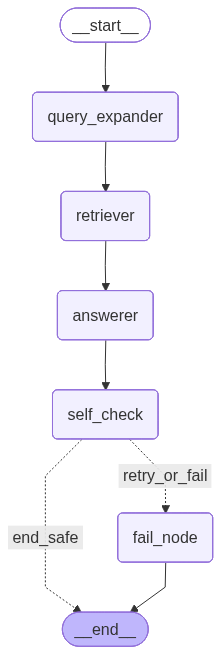

In [3]:
graph = build_graph()
display(Image(graph.get_graph().draw_mermaid_png()))

### Testando com um exemplo bom (Com depuração)

In [4]:
inputs = {"question": "Me fale venda casada"}
    
print("\n--- INICIANDO EXECUÇÃO DO GRAFO (COM SELF-CHECK) ---")

final_aggregated_state = {}

for output in graph.stream(inputs):

    node_name, patch = list(output.items())[0]
    
    print(f"\nNó '{node_name}' finalizado.")
    
    final_aggregated_state.update(patch)
    
    if node_name == "self_check":
        print(f"--- VEREDITO DO SELF-CHECK: {patch['verdict'].verdict} ---")
        
        
# --- Fim do Grafo ---
print("\n--- EXECUÇÃO DO GRAFO CONCLUÍDA ---")

final_answer = final_aggregated_state.get("answer", "ERRO: Chave 'answer' não encontrada no estado final.")

print("\n--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---\n")
print(final_answer)



--- INICIANDO EXECUÇÃO DO GRAFO (COM SELF-CHECK) ---
 --- EXECUTANDO NÓ: QUERY EXPANDER ---
--- CONSULTAS EXPANDIDAS: ['o que é venda condicionada no código do consumidor', 'venda casada equivalente jurídico', 'proibição de venda condicionada lei', 'venda casada no código do consumidor', 'venda condicionada lei brasileira', 'Me fale sobre venda condicionada'] ---

Nó 'query_expander' finalizado.
--- EXECUTANDO NÓ: RETRIEVER ---

Nó 'retriever' finalizado.
--- EXECUTANDO NÓ: ANSWERER ---

Nó 'answerer' finalizado.
--- EXECUTANDO NÓ: SELF-CHECK ---
--- VEREDITO DO SELF-CHECK: fiel ---

Nó 'self_check' finalizado.
--- VEREDITO DO SELF-CHECK: fiel ---

--- EXECUÇÃO DO GRAFO CONCLUÍDA ---

--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---

Com base nos documentos fornecidos, não encontrei informações sobre a venda condicionada no contexto do Código de Defesa do Consumidor.


### Testando com um exemplo ruim

In [8]:
inputs = {"question": "Quem foi michel jackson?"}
    
final_state = graph.invoke(inputs)

final_answer = final_state.get("answer", "ERRO: Chave 'answer' não encontrada no estado final.")

print("\n--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---\n")
print(final_answer)

print("\n--- DADOS DE VERIFICAÇÃO ---")
print(f"Veredito: {final_state['verdict'].verdict}")
print(f"Motivo: {final_state['verdict'].reasoning}")

--- EXECUTANDO NÓ: RETRIEVER ---
--- EXECUTANDO NÓ: ANSWERER ---
--- Utilizando o provedor de LLM: gemini | Modelo: gemini-2.5-flash ---
--- EXECUTANDO NÓ: SELF-CHECK ---
--- Utilizando o provedor de LLM: gemini | Modelo: gemini-2.5-flash ---
--- VEREDITO DO SELF-CHECK: nao_fiel ---
--- EXECUTANDO NÓ: FALHA (RESPOSTA NÃO FIEL) ---

--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---

Não consegui gerar uma resposta confiável com base nos documentos disponíveis. (Motivo da falha interna: A resposta afirma 'não encontrei informações sobre este tópico'. Esta é uma afirmação factual sobre o resultado da busca do modelo. No entanto, as regras de fidelidade exigem que 'todas as afirmações factuais na resposta estejam DIRETAMENTE E SEMANTICAMENTE suportadas por trechos nos documentos de evidência'. Os documentos de evidência fornecidos *contêm* diversas informações. A afirmação de que 'não encontrei informações' não é suportada por nenhum trecho dos documentos. Os documentos não contêm uma declaração de